### Lesson07. Обработка видео

In [1]:
import os
import re
import random
import numpy as np
import tensorflow as tf
import skvideo.io
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Загрузка датасета KTH
# !wget http://www.nada.kth.se/cvap/actions/walking.zip
# !wget http://www.nada.kth.se/cvap/actions/jogging.zip
# !wget http://www.nada.kth.se/cvap/actions/running.zip
# !wget http://www.nada.kth.se/cvap/actions/boxing.zip
# !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
# !wget http://www.nada.kth.se/cvap/actions/handclapping.zip

In [4]:
# !mkdir dataset
# !unzip walking.zip -d dataset
# !unzip jogging.zip -d dataset
# !unzip running.zip -d dataset
# !unzip boxing.zip -d dataset
# !unzip handwaving.zip -d dataset
# !unzip handclapping.zip -d dataset

In [5]:
# Готовим датасет
classes = ['walking', 'jogging', 'running', 'boxing', 'handwaving', 'handclapping']

dataset = []
data_root = 'dataset/'
for filename in os.listdir(data_root):
    if 'avi' not in os.path.splitext(filename)[1]:
        continue
    class_name = filename.split('_')[1]
    dataset.append((os.path.join(data_root, filename), classes.index(class_name)))

In [6]:
dataset[:10]

[('dataset/person14_jogging_d4_uncomp.avi', 1),
 ('dataset/person17_handwaving_d3_uncomp.avi', 4),
 ('dataset/person10_walking_d4_uncomp.avi', 0),
 ('dataset/person10_boxing_d3_uncomp.avi', 3),
 ('dataset/person02_walking_d3_uncomp.avi', 0),
 ('dataset/person11_running_d1_uncomp.avi', 2),
 ('dataset/person07_running_d2_uncomp.avi', 2),
 ('dataset/person23_boxing_d3_uncomp.avi', 3),
 ('dataset/person05_handwaving_d4_uncomp.avi', 4),
 ('dataset/person17_jogging_d2_uncomp.avi', 1)]

In [7]:
len(dataset)

599

In [8]:
random.shuffle(dataset)
# dataset = dataset[:200] # Погоняем на полном датасете

In [9]:
def read_data(data=dataset):
    for item in data:
        videodata = skvideo.io.vread(item[0]).astype(np.float32)/255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        # Чтобы можно было составить их в батч...
        if motion.shape[0] > 512:
            motion = motion[:512, :, :, :]
        else:
            motion = np.pad(motion, ((512-motion.shape[0], 0), (0, 0), (0, 0), (0, 0)))
        label = item[1]
        yield motion, tf.cast(label, tf.uint8)

In [10]:
tf_dataset = tf.data.Dataset.from_generator(read_data,
                                            output_shapes=((None, 120, 160, 1), (None)),
                                            output_types=(tf.float32, tf.uint8))

In [11]:
tf_dataset

<FlatMapDataset shapes: ((None, 120, 160, 1), <unknown>), types: (tf.float32, tf.uint8)>

In [12]:
# Train - val (20 примеров для валидации)
tf_dataset.shuffle(len(dataset))
train_dataset = tf_dataset.skip(20)
val_dataset = tf_dataset.take(20)

In [13]:
# Оптимизация и батчи
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(dataset)-20)
train_dataset = train_dataset.batch(6)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(5)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
# Модел
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation=None)
])

In [16]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(0.001))

Epoch 1/10
97/97 [==============================] - 609s 2s/step - loss: 1.4545 - val_loss: 2.0197
Epoch 2/10
97/97 [==============================] - 139s 1s/step - loss: 0.9249 - val_loss: 2.7666
Epoch 3/10
97/97 [==============================] - 139s 1s/step - loss: 0.6935 - val_loss: 2.7546
Epoch 4/10
97/97 [==============================] - 139s 1s/step - loss: 0.5360 - val_loss: 2.6823
Epoch 5/10
97/97 [==============================] - 139s 1s/step - loss: 0.5304 - val_loss: 1.0777
Epoch 6/10
97/97 [==============================] - 140s 1s/step - loss: 0.4631 - val_loss: 0.7516
Epoch 7/10
97/97 [==============================] - 140s 1s/step - loss: 0.4147 - val_loss: 0.3879
Epoch 8/10
97/97 [==============================] - 140s 1s/step - loss: 0.4346 - val_loss: 0.8275
Epoch 9/10
97/97 [==============================] - 140s 1s/step - loss: 0.3644 - val_loss: 0.9540
Epoch 10/10
97/97 [==============================] - 140s 1s/step - loss: 0.3383 - val_loss: 2.7755
CPU times

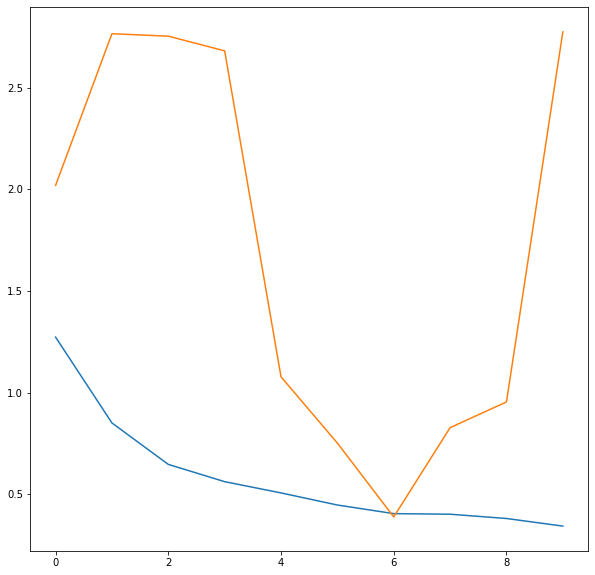

In [17]:
%%time
hist = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

plt.figure(figsize=(10, 10))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.plot(range(len(hist.history['loss'])), hist.history['val_loss'])
plt.draw()

In [18]:
# Что-то чудовищно неравномерно на валидации...

In [19]:
# Попробуем посмотреть, чему оно научилось..

In [20]:
test_batch = iter(val_dataset).next()

In [22]:
result = model.predict(test_batch[0][0][None, ...])

In [23]:
np.argmax(result)

2

In [24]:
classes[2]

'running'

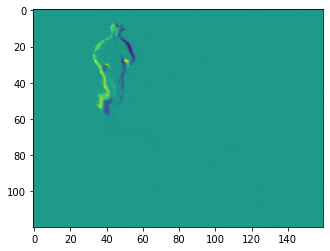

In [32]:
plt.imshow(test_batch[0][0][50])

In [28]:
# Похоже на правду. Я бы конечно это назвал jogging, ну да ладно

In [50]:
# Еще поучим. Может скор станет получше

In [ ]:
%%time
hist2 = model.fit(train_dataset, epochs=30, validation_data=val_dataset)

plt.figure(figsize=(10, 10))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.plot(range(len(hist.history['loss'])), hist.history['val_loss'])
plt.draw()

Epoch 1/30
97/97 [==============================] - 141s 1s/step - loss: 0.3123 - val_loss: 0.6709
Epoch 2/30
35/97 [=========>....................] - ETA: 1:29 - loss: 0.2960